# Neuropixel Spiking and LFP analysis

- [Original Article](https://www.nature.com/articles/s41586-019-1787-x)
- [Neuromatch Notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_steinmetz_decisions.ipynb#scrollTo=J4a1U2AnrDb_)
- [Dataset](https://uni-bonn.sciebo.de/s/Z66tPbIFGGSA3FD)

## Import

In [71]:
import numpy as np
import scipy.signal as sig
import netCDF4 as nc
import matplotlib.pyplot as plt
from pathlib import Path
import os
import scipy.stats as stats
from specparam import SpectralModel, SpectralGroupModel
from specparam.analysis import get_band_peak_group
import seaborn as sns

## Load data

In [2]:
# create path for sourcedata steinmetz using pathlib
source_path = Path(os.getcwd()).parent / "sourcedata"
data_path = os.path.join(source_path, "steinmetz_2016-12-14_Cori.nc")
data = nc.Dataset(data_path)

## Extract LFP

In [3]:
brain_area = "MOs"
brain_area_lfp_idx = np.where(data.variables["brain_area_lfp"][:] == brain_area)[0][0]
area_lfp = data.variables["lfp"][brain_area_lfp_idx].data

## Extract spiking

In [4]:
brain_area = "MOs"
brain_area_spike_idx = np.where(data.variables["brain_area"][:] == brain_area)[0]
brain_area_spike_idx
area_spiking = data.variables["spike_rate"][brain_area_spike_idx].data

spiking_activity = np.mean(area_spiking, axis=0)

In [5]:
assert area_lfp.shape == spiking_activity.shape, "Shapes don't match"

## Correlate mean trial PSD with trial spiking activity

In [117]:
median_psd = np.median(pwr, axis=1)

median_psd.shape

(364,)

In [116]:
sample_rate = 100
freqs, pwr = sig.welch(area_lfp, fs=sample_rate, nperseg=sample_rate // 2)

mean_psd = np.mean(pwr, axis=1)
median_psd = np.median(pwr, axis=1)

mean_spiking_activity = np.sum(spiking_activity, axis=1)

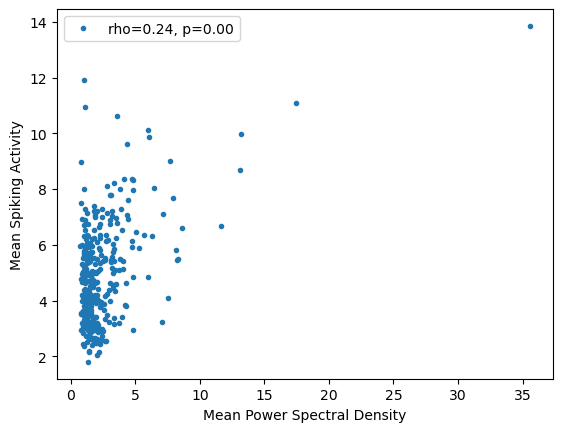

In [101]:
rho, pval = stats.spearmanr(mean_psd, mean_spiking_activity)

plt.plot(mean_psd, mean_spiking_activity, ".", label=f"rho={rho:.2f}, p={pval:.2f}")
plt.xlabel("Mean Power Spectral Density")
plt.ylabel("Mean Spiking Activity")
plt.legend();

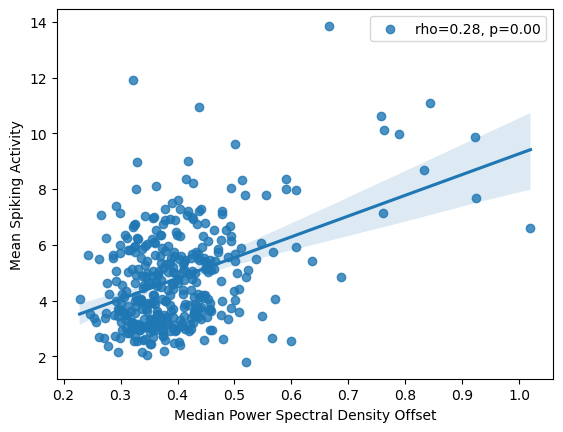

In [103]:
rho, pval = stats.spearmanr(median_psd, mean_spiking_activity)

fig, ax = plt.subplots()
sns.regplot(x=median_psd, y=mean_spiking_activity, label=f"rho={rho:.2f}, p={pval:.2f}", ax=ax)
ax.set_xlabel("Median Power Spectral Density Offset")
ax.set_ylabel("Mean Spiking Activity")
ax.legend();

## Correlation for each single neuron

In [106]:
area_spiking.shape

(113, 364, 250)

In [109]:
area_spiking[neuron].shape

(364, 250)

In [114]:
rhos = []
pvals = []
for neuron in range(area_spiking.shape[0]):
    single_neuron_spike_rate = area_spiking[neuron].mean(-1)
    rho, pval = stats.spearmanr(mean_psd, single_neuron_spike_rate)
    rhos.append(rho)
    pvals.append(pval)
rhos = np.array(rhos)
pvals = np.array(pvals)

argmax = np.argmax(rhos)

print(f"Max idx={argmax}: rho={rhos[argmax]:.2f}, p={pvals[argmax]:.2f}")

Max idx=59: rho=0.56, p=0.00


## Fit FOOOF

In [10]:
fooof_params = {"max_n_peaks": 1, "peak_width_limits": (4, 8), "verbose": True}
fit_range = [1, 50]

Fitting model across 364 power spectra.
Fitting model across 364 power spectra.
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                            Number of power spectra in the Group: 364                             
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                             

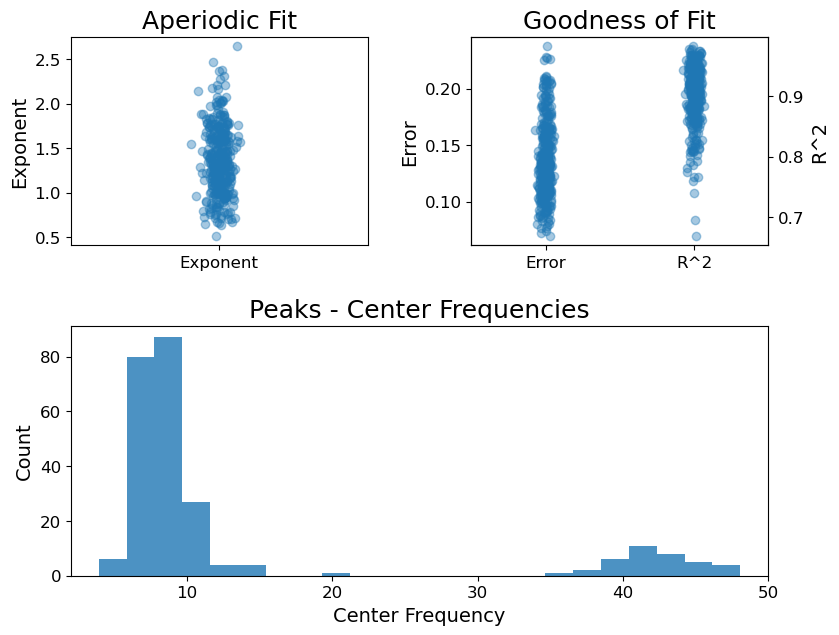

In [11]:
fg = SpectralGroupModel(**fooof_params)
fg.fit(freqs, pwr, freq_range=fit_range)
fg.report()

## Extract parameters

In [12]:
exps = fg.get_params('aperiodic_params', 'exponent')
offsets = fg.get_params('aperiodic_params', 'offset')
peaks = fg.get_params('peak_params')

## Correlate Exponents and Spiking

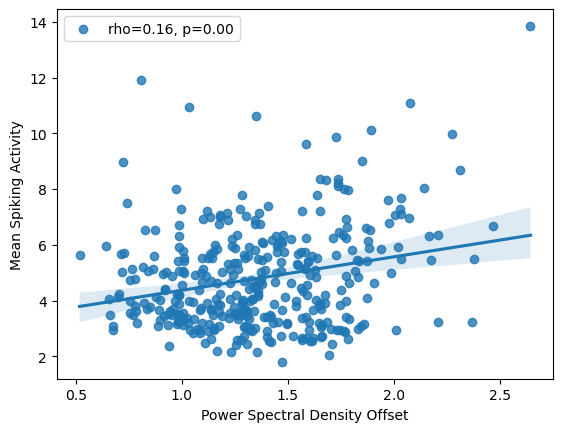

In [21]:
rho, pval = stats.spearmanr(exps, mean_spiking_activity)

fig, ax = plt.subplots()
sns.regplot(x=exps, y=mean_spiking_activity, label=f"rho={rho:.2f}, p={pval:.2f}", ax=ax)
ax.set_xlabel("Power Spectral Density Offset")
ax.set_ylabel("Mean Spiking Activity")
ax.legend();

## Correlate Offset and Spiking

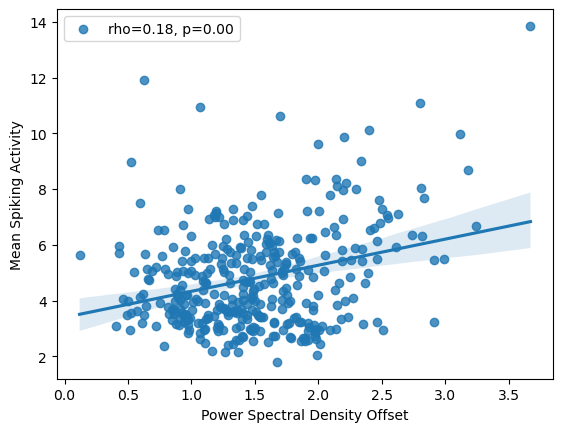

In [23]:
rho, pval = stats.spearmanr(offsets, mean_spiking_activity)

fig, ax = plt.subplots()
sns.regplot(x=offsets, y=mean_spiking_activity, label=f"rho={rho:.2f}, p={pval:.2f}", ax=ax)
ax.set_xlabel("Power Spectral Density Offset")
ax.set_ylabel("Mean Spiking Activity")
ax.legend();

## Correlate Mean aperiodic PSD and Spiking

In [58]:
# fm = SpectralModel(**fooof_params)
# fm.fit(freqs, pwr[0], freq_range=fit_range)
# fm.report(plt_log=False)

In [59]:
# exp = fm.get_params('aperiodic_params', 'exponent')
# offset = fm.get_params('aperiodic_params', 'offset')
# aperiodic_power = 10**offset * freqs[1:]**(-exp)
# mean_ap = aperiodic_power.mean()
# mean_ap = np.ones(freqs[1:].shape) * mean_ap
# plt.loglog(freqs[1:], aperiodic_power, label="Model Fit")
# plt.loglog(freqs[1:], pwr[0][1:], label="Power Spectrum")
# plt.loglog(freqs[1:], mean_ap, label="Mean Aperiodic Power")
# plt.legend();

In [60]:
# repeat for entire pwr array in loop
fm = SpectralModel(**fooof_params)
mean_aps = []
for trial_pwr in pwr:
    fm.fit(freqs, trial_pwr, freq_range=fit_range)
    offset, exp = fm.get_params('aperiodic_params')
    aperiodic_power = 10**offset * freqs[1:]**(-exp)
    mean_ap = aperiodic_power.mean()
    mean_aps.append(mean_ap)
mean_aps = np.array(mean_aps)

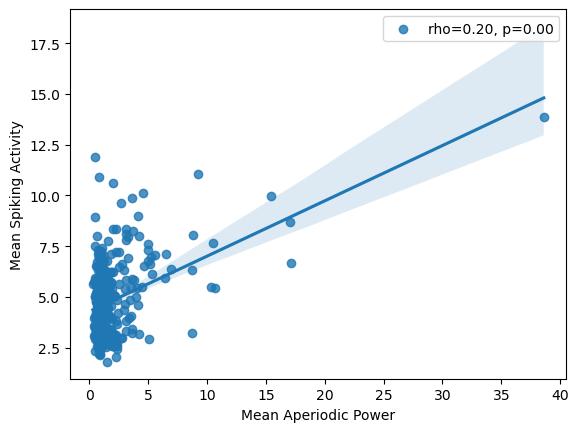

In [62]:
rho, pval = stats.spearmanr(mean_aps, mean_spiking_activity)

fig, ax = plt.subplots()
sns.regplot(x=mean_aps, y=mean_spiking_activity, label=f"rho={rho:.2f}, p={pval:.2f}", ax=ax)
ax.set_xlabel("Mean Aperiodic Power")
ax.set_ylabel("Mean Spiking Activity")
ax.legend();

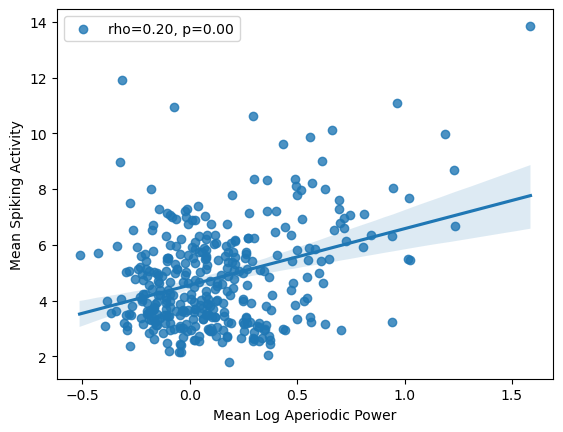

In [64]:
log_aps = np.log10(mean_aps)

rho, pval = stats.spearmanr(log_aps, mean_spiking_activity)

fig, ax = plt.subplots()
sns.regplot(x=log_aps, y=mean_spiking_activity, label=f"rho={rho:.2f}, p={pval:.2f}", ax=ax)
ax.set_xlabel("Mean Log Aperiodic Power")
ax.set_ylabel("Mean Spiking Activity")
ax.legend();

## Correlate oscillation amplitude and spiking

In [82]:
n_oscillations = np.sum(np.isfinite(get_band_peak_group(fg, fit_range)).sum(1) == 3)
print(f"Total oscillations found {n_oscillations}")
n_theta = np.sum(np.isfinite(get_band_peak_group(fg, [4, 8])).sum(1) == 3)
print(f"Total theta oscillations found {n_theta}")
n_alpha = np.sum(np.isfinite(get_band_peak_group(fg, [8, 12])).sum(1) == 3)
print(f"Total alpha oscillations found {n_alpha}")
n_theta_alpha = np.sum(np.isfinite(get_band_peak_group(fg, [4, 12])).sum(1) == 3)
print(f"Total theta-alpha oscillations found {n_theta_alpha}")

Total oscillations found 246
Total theta oscillations found 100
Total alpha oscillations found 101
Total theta-alpha oscillations found 201


In [89]:
theta_pwr = get_band_peak_group(fg, [4, 8])[:, 1]
alpha_pwr = get_band_peak_group(fg, [8, 12])[:, 1]
theta_alpha_pwr = get_band_peak_group(fg, [4, 12])[:, 1]

# replace nan with 0
theta_pwr[np.isnan(theta_pwr)] = 0
alpha_pwr[np.isnan(alpha_pwr)] = 0
theta_alpha_pwr[np.isnan(theta_alpha_pwr)] = 0

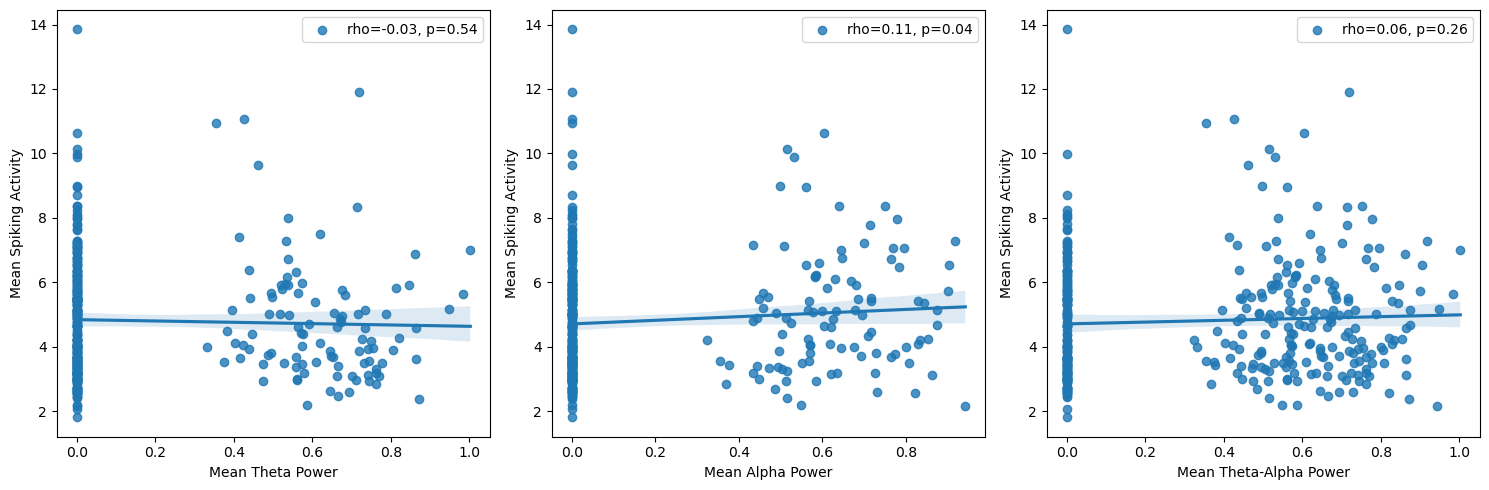

In [92]:
powers = [theta_pwr, alpha_pwr, theta_alpha_pwr]
powers_str = ["Theta Power", "Alpha Power", "Theta-Alpha Power"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (power, power_str) in enumerate(zip(powers, powers_str)):
    x = power
    y = mean_spiking_activity

    rho, pval = stats.spearmanr(x, y)

    sns.regplot(x=x, y=y, label=f"rho={rho:.2f}, p={pval:.2f}", ax=ax[i])
    ax[i].set_xlabel(f"Mean {power_str}")
    ax[i].set_ylabel("Mean Spiking Activity")
    ax[i].legend()
plt.tight_layout();